In [ ]:
# get price per metro
# get rent per metro
# get unemployment per metro
# find indicators for house price change

In [313]:
from itertools import product
import re
import pandas as pd
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [206]:
home_forecast = pd.read_csv('data/real_estate/AllRegionsForePublic.csv')

In [3]:
median_rent = pd.read_csv('data/real_estate/City_MedianRentalPrice_AllHomes.csv')

In [5]:
zhvi = pd.read_csv('data/real_estate/City_Zhvi_Summary_AllHomes2.csv')

In [7]:
zri = pd.read_csv('data/real_estate/City_Zri_AllHomesPlusMultifamily_Summary2.csv')

In [8]:
rent_forecast = pd.read_csv('data/real_estate/ZriForecast_Public.csv')

In [9]:
sale_price = pd.read_csv('data/real_estate/Sale_Prices_City-2.csv')

In [ ]:
# criteria:
    # minimize price to rent ratio
    # above average expected growth
    # reasonable house price (up to 50k down - 250k price)
    # close to home
    
# need to check:
    # tax
    # vacancy

# Price to Rent

In [137]:
median_rent['FullName'] = median_rent['RegionName'] + " " + median_rent['State']

In [138]:
median_rent.head()

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,FullName
0,New York,NY,New York-Newark-Jersey City,Queens County,1,NaN,NaN,NaN,NaN,2297.5,...,2800.0,2800.0,2800.0,2850.0,2900.0,2895.0,2850.0,2905.0,2900.0,New York NY
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,NaN,NaN,NaN,NaN,NaN,...,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3600.0,3607.0,Los Angeles CA
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN,NaN,...,1500.0,1500.0,1500.0,1525.0,1550.0,1550.0,1550.0,1550.0,1550.0,Houston TX
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,NaN,1600.0,1500.0,1500.0,1500.0,...,1750.0,1728.5,1775.0,1795.0,1800.0,1800.0,1800.0,1813.5,1800.0,Chicago IL
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,NaN,NaN,NaN,NaN,NaN,...,1295.0,1295.0,1300.0,1300.0,1325.0,1344.5,1349.0,1325.0,1299.5,San Antonio TX


In [234]:
median_rent[median_rent['RegionName']== 'Birmingham']

,RegionName,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,FullName
120,Birmingham,AL,Birmingham-Hoover,Jefferson County,121,NaN,NaN,NaN,NaN,NaN,...,850.0,850.0,850.0,885.0,900.0,895.0,885.0,850.0,850.0,Birmingham AL
1498,Birmingham,MI,Detroit-Warren-Dearborn,Oakland County,1499,NaN,NaN,NaN,NaN,NaN,...,2000.0,2100.0,1972.5,1995.0,2000.0,2100.0,2200.0,2250.0,2200.0,Birmingham MI


In [155]:
median_rent.isna().sum().tail(10)

2019-01     0
2019-02     0
2019-03     0
2019-04     0
2019-05     0
2019-06     0
2019-07     0
2019-08     0
2019-09     0
FullName    0
dtype: int64

In [109]:
state_abbrev = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations')

In [117]:
state_abbrev_df = state_abbrev[0]

In [127]:
state_abbrev_dict = state_abbrev_df.T.reset_index(drop=True).T.set_index(0)[3].to_dict()

In [134]:
sale_price['StateAbbrev'] = sale_price['StateName'].apply(lambda x: state_abbrev_dict[x])

In [135]:
sale_price['FullName'] = sale_price['RegionName'] + " " + sale_price['StateAbbrev']

In [136]:
sale_price.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,StateAbbrev,FullName
0,12447,Los Angeles,California,1,502500.0,486800.0,463300.0,454100.0,434500.0,420500.0,...,684700.0,698200.0,700600.0,705800.0,708900.0,711700.0,714300.0,710400.0,CA,Los Angeles CA
1,17426,Chicago,Illinois,2,326200.0,316800.0,293300.0,279000.0,273600.0,270100.0,...,269200.0,299600.0,299600.0,290000.0,281500.0,277100.0,273200.0,272400.0,IL,Chicago IL
2,13271,Philadelphia,Pennsylvania,3,110400.0,110700.0,111700.0,110200.0,108400.0,111200.0,...,157300.0,156000.0,158500.0,159600.0,163700.0,165700.0,169800.0,NaN,PA,Philadelphia PA
3,40326,Phoenix,Arizona,4,221600.0,212400.0,204300.0,195700.0,186400.0,176600.0,...,228300.0,232700.0,233100.0,235000.0,236900.0,237500.0,236000.0,237400.0,AZ,Phoenix AZ
4,18959,Las Vegas,Nevada,5,245700.0,239900.0,235100.0,226000.0,217800.0,207600.0,...,267800.0,270900.0,266400.0,266600.0,265900.0,269700.0,271200.0,271700.0,NV,Las Vegas NV


In [235]:
sale_price[sale_price['RegionName']== 'Birmingham']

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,StateAbbrev,FullName,forcast


In [154]:
sale_price.isna().sum().tail(10)

2019-02           1
2019-03          22
2019-04          29
2019-05          53
2019-06          98
2019-07         110
2019-08         150
2019-09        1836
StateAbbrev      11
FullName         11
dtype: int64

In [151]:
sale_price_2019 = sale_price.set_index('FullName').loc[:,'2019-02']

In [152]:
sale_price_2019.name = 'price'

In [156]:
median_rent_2019 = median_rent.set_index('FullName').loc[:,'2019-02']

In [157]:
median_rent_2019.name = 'rent'

In [158]:
sale_price_2019.head()

FullName
Los Angeles CA     684700.0
Chicago IL         269200.0
Philadelphia PA    157300.0
Phoenix AZ         228300.0
Las Vegas NV       267800.0
Name: price, dtype: float64

In [159]:
median_rent_2019.head()

FullName
New York NY       2800.0
Los Angeles CA    3500.0
Houston TX        1500.0
Chicago IL        1728.5
San Antonio TX    1295.0
Name: rent, dtype: float64

In [160]:
city_df = median_rent_2019.to_frame().merge(sale_price_2019.to_frame(), left_index=True, right_index=True)

In [98]:
city_df = city_df.dropna()

In [161]:
city_df.head()

,rent,price
FullName,,
Abingdon MD,1650.0,229500.0
Acworth GA,1500.0,238300.0
Agoura Hills CA,3450.0,987400.0
Aiken SC,1225.0,140200.0
Akron OH,775.0,68300.0


In [162]:
city_df['price_to_rent'] = city_df['price']/city_df['rent']

In [467]:
city_df['state'] = sale_price.set_index('FullName')['StateAbbrev']

In [198]:
city_df = city_df.sort_values(by='price_to_rent')

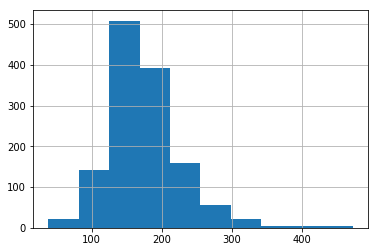

In [167]:
city_df['price_to_rent'].hist()

# Forecast

## Price Forecast

In [202]:
home_forecast['Region'].unique()

array(['Country', 'State', 'County', 'Msa', 'City', 'Neighborhood', 'Zip'],
      dtype=object)

In [207]:
home_forecast = home_forecast[home_forecast['Region']=='City']

In [211]:
home_forecast['FullName'] = home_forecast['CityName'] + " " + home_forecast['StateName']

In [215]:
home_forecast.head()

,Region,RegionName,StateName,CountyName,CityName,ForecastYoYPctChange
FullName,,,,,,
Aberdeen ID,City,Aberdeen,ID,Bingham County,Aberdeen,6.723185
Aberdeen NC,City,Aberdeen,NC,Moore County,Aberdeen,2.615473
Aberdeen MD,City,Aberdeen,MD,Harford County,Aberdeen,2.133168
Aberdeen WA,City,Aberdeen,WA,Grays Harbor County,Aberdeen,5.370652
Aberdeen MS,City,Aberdeen,MS,Monroe County,Aberdeen,1.907417


In [213]:
home_forecast = home_forecast.set_index('FullName')

In [217]:
home_forecast = home_forecast[~home_forecast.index.duplicated()]

In [195]:
city_df = city_df[~city_df.index.duplicated()]

In [218]:
city_df['forecast'] = home_forecast['ForecastYoYPctChange']

In [221]:
city_df['state'] = home_forecast['StateName']

In [233]:
city_df[city_df['state']=='AL']

,rent,price,price_to_rent,forecast,state
FullName,,,,,
Hueytown AL,900.0,97100.0,107.888889,1.529017,AL
Montgomery AL,850.0,107700.0,126.705882,1.059200,AL
Dothan AL,1100.0,139600.0,126.909091,-1.260515,AL
Foley AL,1350.0,180000.0,133.333333,2.516662,AL
Calera AL,1250.0,167400.0,133.920000,3.361010,AL
Daphne AL,1300.0,179600.0,138.153846,1.347739,AL
Alabaster AL,1250.0,183200.0,146.560000,4.089921,AL
Madison AL,1350.0,200100.0,148.222222,2.399132,AL
Tuscaloosa AL,1350.0,201700.0,149.407407,2.362939,AL


In [237]:
city_df[city_df.forecast>1].head(50)

,rent,price,price_to_rent,forecast,state
FullName,,,,,
Maple Heights OH,930.0,52400.0,56.344086,2.260637,OH
Century Village FL,950.0,55500.0,58.421053,4.202020,FL
South Holland IL,1902.0,118100.0,62.092534,1.667838,IL
Rochester NY,1100.0,72700.0,66.090909,1.492843,NY
South Euclid OH,1150.0,79300.0,68.956522,1.702731,OH
Syracuse NY,1200.0,83600.0,69.666667,3.404178,NY
Euclid OH,975.0,73600.0,75.487179,3.361613,OH
Englewood FL,2600.0,199100.0,76.576923,1.298288,FL
Ewing NJ,2025.0,160500.0,79.259259,1.861157,NJ


In [513]:
city_df['forecast'].mean()

2.1207557001458515

## Rent forecast

In [492]:
rent_forecast.head()

,RegionID,RegionName,RegionType,SizeRank,ZriForecast,Forecast_YoY_Change,Current_YoY_Change
0,102001,United States,Country,0,1629,0.020038,0.021753
1,394913,"New York, NY",Msa,1,2352,0.027523,0.010150
2,753899,"Los Angeles-Long Beach-Anaheim, CA",Msa,2,2663,0.019525,0.004229
3,394463,"Chicago, IL",Msa,3,1650,0.018519,0.027919
4,394514,"Dallas-Fort Worth, TX",Msa,4,1486,0.029086,0.016901


In [493]:
rent_forecast['RegionType'].unique()

array(['Country', 'Msa'], dtype=object)

In [495]:
rent_forecast = rent_forecast[rent_forecast['RegionType']=='Msa']

In [502]:
new_index = rent_forecast['RegionName'].progress_apply(format_city).stack().to_frame().reset_index()

In [505]:
rent_forecast = rent_forecast.merge(new_index, left_index=True, right_on='level_0')

In [506]:
rent_forecast.head()

,RegionID,RegionName,RegionType,SizeRank,ZriForecast,Forecast_YoY_Change,Current_YoY_Change,level_0,level_1,0
0,394913,"New York, NY",Msa,1,2352,0.027523,0.010150,1,0,New York NY
1,753899,"Los Angeles-Long Beach-Anaheim, CA",Msa,2,2663,0.019525,0.004229,2,0,Los Angeles CA
2,753899,"Los Angeles-Long Beach-Anaheim, CA",Msa,2,2663,0.019525,0.004229,2,1,Long Beach CA
3,753899,"Los Angeles-Long Beach-Anaheim, CA",Msa,2,2663,0.019525,0.004229,2,2,Anaheim CA
4,394463,"Chicago, IL",Msa,3,1650,0.018519,0.027919,3,0,Chicago IL


In [507]:
rent_forecast = rent_forecast.set_index(0)

In [217]:
home_forecast = home_forecast[~home_forecast.index.duplicated()]

In [508]:
city_df['rent_forecast'] = rent_forecast['Forecast_YoY_Change']

In [510]:
city_df[~city_df['rent_forecast'].isna()].head()

,rent,price,price_to_rent,StateAbbrev,forecast,state,vacancy,vacancy_rent,price_to_vacancy_rent,income,ROI,medianPropertyTax,2018,rent_forecast
Richmond VA,1350.0,199900.0,148.074074,VA,1.879924,VA,8.0,1242.000,160.950081,13424.74,0.067157,0.0074,8.0,0.027946
Virginia Beach VA,1475.0,252600.0,171.254237,VA,1.751755,VA,8.9,1343.725,187.984893,14255.46,0.056435,0.0074,8.9,0.020134
Philadelphia PA,1450.0,157300.0,108.482759,PA,0.675222,PA,9.0,1319.500,119.211823,13710.45,0.087161,0.0135,9.0,0.016644
Pittsburgh PA,1400.0,164100.0,117.214286,PA,-0.794372,PA,10.2,1257.200,130.528158,12871.05,0.078434,0.0135,10.2,-0.000912
Anaheim CA,2675.0,580300.0,216.934579,CA,2.489650,CA,6.6,2498.450,232.264004,25687.18,0.044265,0.0074,6.6,0.019525


In [512]:
city_df['rent_forecast'].mean()

0.028247593396902974

# Vacancy

In [238]:
!pip install geopy

    100% |████████████████████████████████| 102kB 4.2MB/s a 0:00:011
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [250]:
import time

In [256]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
def get_geocode(name):
    time.sleep(1)
    return geolocator.geocode(name).point




/Users/jordanvalansi/.virtualenv/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [371]:
# city_df['geocode'] = city_df.reset_index()['FullName'].progress_apply(get_geocode)


In [348]:
df = pd.read_csv('data/real_estate/ann18t_8.csv', header=5, index_col=1)

In [349]:
def format_city(city):
    """
    convert
    >>> list(format_city("Allentown-Bethlehem-Easton, PA-NJ"))
    ['Allentown PA', 'Allentown NJ', 'Bethlehem PA', 'Bethlehem NJ', 'Easton PA', 'Easton NJ']
    """
    try:
        city = re.sub('[\.…]', '', city)
        cities, states = city.split(", ")
        cities = cities.split('-')
        states = states.split('-')
        return pd.Series([c+' '+re.sub('\d', '', s) for c,s in product(cities, states)])
    except (ValueError,AttributeError,TypeError):
        return pd.Series()

In [350]:
from doctest import testmod
testmod()

TestResults(failed=0, attempted=1)

In [351]:
df = df.reset_index()

In [352]:
df = df.dropna(subset=['2018'])

In [353]:
new_index = df['index'].progress_apply(format_city).stack().to_frame()

In [ ]:
new_df = new_index.reset_index().merge(df, left_on='level_0', right_index=True)

In [364]:
df.head()

,index,Unnamed: 0,2015,2016,2017,2018,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
1,Inside Metropolitan Statistical Areas..........,NaN,11.3,11.3,11.3,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Akron, OH .......................................",NaN,11.6,10.4,8.8,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albany-Schenectady-Troy, NY .....................",NaN,13.2,11.8,10.5,11.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Albuquerque, NM..................................",NaN,9.3,9.2,8.9,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Allentown-Bethlehem-Easton, PA-NJ................",NaN,9.1,7.4,9.5,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
new_index = new_index.reset_index()

In [366]:
new_df = new_index.reset_index().merge(df, left_on='level_0', right_index=True)

In [370]:
vacancy_df = new_df.set_index(0)['2018'].to_frame()

In [377]:
vacancy_df.loc['Hayward CA']

2018    7.5
Name: Hayward CA, dtype: float64

In [489]:
city_df = city_df.merge(vacancy_df, left_index=True, right_index=True, suffixes=("", "_"))

In [490]:
city_df.head()

,rent,price,price_to_rent,StateAbbrev,forecast,state,vacancy,vacancy_rent,price_to_vacancy_rent,income,ROI,medianPropertyTax,2018
Albuquerque NM,1295.0,201800.0,155.830116,NM,2.626413,NM,8.3,1187.515,169.934696,13140.280,0.065115,0.0055,8.3
Alexandria VA,2225.0,490600.0,220.494382,VA,NaN,VA,7.0,2069.250,237.090733,21200.560,0.043214,0.0074,7.0
Arlington VA,2390.0,608200.0,254.476987,VA,2.761909,VA,7.0,2222.700,273.631169,22171.720,0.036455,0.0074,7.0
Newport News VA,1200.0,174800.0,145.666667,VA,1.295946,VA,8.9,1093.200,159.897548,11824.880,0.067648,0.0074,8.9
Norfolk VA,1321.0,191700.0,145.117335,VA,1.761341,VA,8.9,1203.431,159.294550,13022.592,0.067932,0.0074,8.9


# Tax

In [459]:
tax_df = pd.read_csv('data/real_estate/data.csv')

In [462]:
tax_df['StateAbbrev'] = tax_df['State'].apply(lambda x: state_abbrev_dict[x])

In [477]:
city_df = city_df.reset_index().merge(tax_df, on='StateAbbrev').set_index('index')

In [487]:
city_df = city_df.drop('Pop_y', axis=1)

In [479]:
# income = 12*rent*(1-vacancy_rate)-price*tax
city_df['income'] = 12*city_df['vacancy_rent'] - city_df['price']*city_df['medianPropertyTax']

In [482]:
city_df['ROI'] = city_df['income']/city_df['price']

In [511]:
city_df.sort_values('ROI', ascending=False)

,rent,price,price_to_rent,StateAbbrev,forecast,state,vacancy,vacancy_rent,price_to_vacancy_rent,income,ROI,medianPropertyTax,2018,rent_forecast
Rochester NY,1100.0,72700.0,66.090909,NY,1.492843,NY,9.9,991.1000,73.352840,10998.990,0.151293,0.0123,9.9,NaN
Syracuse NY,1200.0,83600.0,69.666667,NY,3.404178,NY,10.8,1070.4000,78.101644,11816.520,0.141346,0.0123,10.8,NaN
Cleveland OH,900.0,66900.0,74.333333,OH,NaN,OH,10.4,806.4000,82.961310,8766.960,0.131046,0.0136,10.4,0.021435
Easton PA,1300.0,102100.0,78.538462,PA,NaN,PA,9.3,1179.1000,86.591468,12770.850,0.125082,0.0135,9.3,NaN
Baltimore MD,1345.0,115600.0,85.947955,MD,-0.165009,MD,10.1,1209.1550,95.603955,13504.140,0.116818,0.0087,10.1,0.008075
Providence RI,2100.0,207500.0,98.809524,RI,2.945463,RI,10.3,1883.7000,110.155545,19803.150,0.095437,0.0135,10.3,0.016061
Allentown PA,1250.0,127200.0,101.760000,PA,4.676368,PA,9.3,1133.7500,112.194046,11887.800,0.093458,0.0135,9.3,NaN
New Haven CT,1400.0,137700.0,98.357143,CT,1.392616,CT,10.9,1247.4000,110.389610,12724.290,0.092406,0.0163,10.9,NaN
Toledo OH,795.0,79800.0,100.377358,OH,2.758024,OH,12.3,697.2150,114.455369,7281.300,0.091244,0.0136,12.3,NaN
Memphis TN,895.0,98000.0,109.497207,TN,NaN,TN,12.6,782.2300,125.282845,8720.360,0.088983,0.0068,12.6,0.027593
